## Verification of single star against Gala

In [7]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde
from sklearn.decomposition import PCA
import sys
import os
from tqdm import tqdm

# add src to sys.path
script_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(script_dir, os.pardir))
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

# add paths of cartesian and covariance data frames
cartesian_df = pd.read_csv(os.path.join(project_root, 'data', 'processed', '6d_cartesian_data.csv'))
covariance_df = pd.read_csv(os.path.join(project_root, 'data', 'processed', '6d_cartesian_covariance.csv'))

# packages
from hvs_orbital_kinematics.potentials import MWPotential
from hvs_orbital_kinematics.integrators import leapfrog_step
import gala.potential as gp
import gala.dynamics as gd
import gala.integrate as gi
from gala.units import galactic
import astropy.units as u

# constants
KM_S_TO_KPC_MYR = (u.km / u.s).to(u.kpc / u.Myr)
print("conversion: " + str(KM_S_TO_KPC_MYR))

conversion: 0.001022712165045695


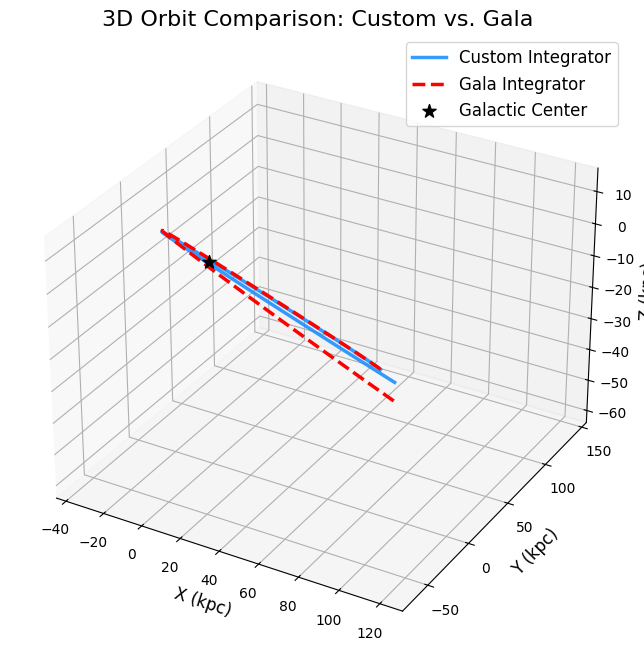

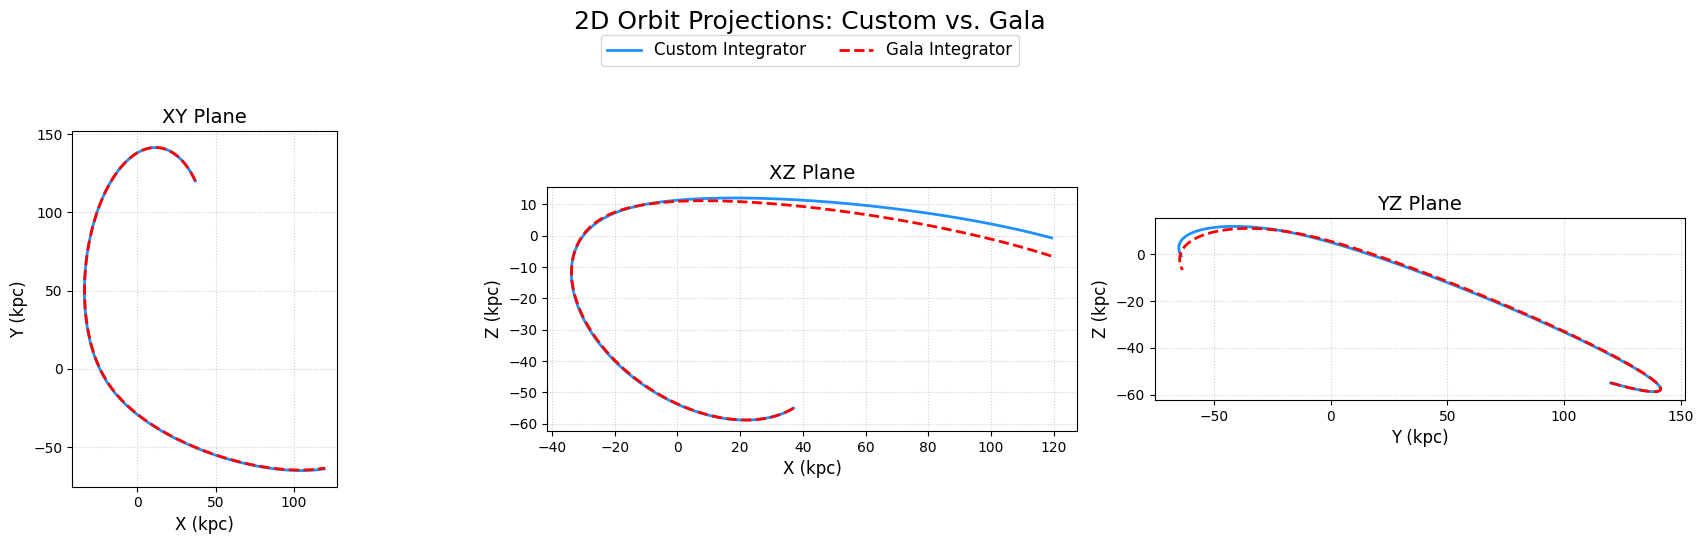

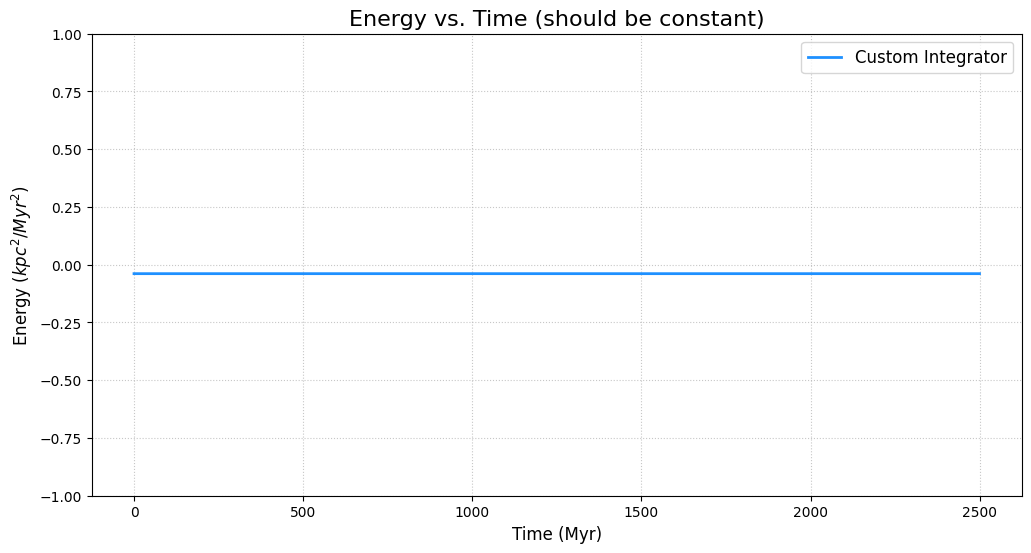

In [28]:
custom_potential = MWPotential()
gala_potential = gp.MilkyWayPotential()

initial_pos = np.array([37, 120, -55])
initial_vel = np.array([38, -81, 23])

initial_vel_kpcmyr = initial_vel * KM_S_TO_KPC_MYR

# custom integration parameters
N_STEPS = 5000
DT = -0.5 # Myr
times = np.arange(0, N_STEPS * DT, DT)

# run custom integrator
my_orbit = np.zeros((N_STEPS, 6))
my_orbit[0] = np.concatenate([initial_pos, initial_vel_kpcmyr])

for i in range(1, N_STEPS):
    prev_pos = my_orbit[i-1, :3]
    prev_vel = my_orbit[i-1, 3:]
    new_pos, new_vel = leapfrog_step(prev_pos, prev_vel, DT, custom_potential.get_acceleration_mw_only)
    my_orbit[i] = np.concatenate([new_pos, new_vel])


# run gala integrator
initial = gd.PhaseSpacePosition(pos=initial_pos * u.kpc,
                                vel=initial_vel * u.km / u.s)
gala_orbit = gala_potential.integrate_orbit(initial, dt=DT * u.Myr,
                                            n_steps=N_STEPS-1,
                                            Integrator=gi.LeapfrogIntegrator)

# plot results
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(my_orbit[:, 0], my_orbit[:, 1], my_orbit[:, 2],
        label='Custom Integrator', lw=2.5, color='dodgerblue', alpha=0.9)

ax.plot(gala_orbit.x, gala_orbit.y, gala_orbit.z,
        label='Gala Integrator', lw=2.5, color='red', linestyle='--')

ax.scatter(0, 0, 0, color='black', s=100, marker='*', label='Galactic Center')

ax.set_xlabel("X (kpc)", fontsize=12)
ax.set_ylabel("Y (kpc)", fontsize=12)
ax.set_zlabel("Z (kpc)", fontsize=12)
ax.set_title("3D Orbit Comparison: Custom vs. Gala", fontsize=16)
ax.legend(fontsize=12)
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5.5))
fig.suptitle('2D Orbit Projections: Custom vs. Gala', fontsize=18)

custom_label = 'Custom Integrator'
gala_label = 'Gala Integrator'

axes[0].plot(my_orbit[:, 0], my_orbit[:, 1], lw=2, color='dodgerblue', label=custom_label)
axes[0].plot(gala_orbit.x.value, gala_orbit.y.value, lw=2, color='red', linestyle='--', label=gala_label)
axes[0].set_xlabel('X (kpc)', fontsize=12)
axes[0].set_ylabel('Y (kpc)', fontsize=12)
axes[0].set_title('XY Plane', fontsize=14)
axes[0].set_aspect('equal', 'box')
axes[0].grid(True, linestyle=':', alpha=0.6)

axes[1].plot(my_orbit[:, 0], my_orbit[:, 2], lw=2, color='dodgerblue')
axes[1].plot(gala_orbit.x.value, gala_orbit.z.value, lw=2, color='red', linestyle='--')
axes[1].set_xlabel('X (kpc)', fontsize=12)
axes[1].set_ylabel('Z (kpc)', fontsize=12)
axes[1].set_title('XZ Plane', fontsize=14)
axes[1].set_aspect('equal', 'box')
axes[1].grid(True, linestyle=':', alpha=0.6)

axes[2].plot(my_orbit[:, 1], my_orbit[:, 2], lw=2, color='dodgerblue')
axes[2].plot(gala_orbit.y.value, gala_orbit.z.value, lw=2, color='red', linestyle='--')
axes[2].set_xlabel('Y (kpc)', fontsize=12)
axes[2].set_ylabel('Z (kpc)', fontsize=12)
axes[2].set_title('YZ Plane', fontsize=14)
axes[2].set_aspect('equal', 'box')
axes[2].grid(True, linestyle=':', alpha=0.6)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=2, fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.90])  # Adjust layout to make room for suptitle and legend
plt.show()

# plot total energy plot
my_KE = 0.5 * np.linalg.norm(my_orbit[:, 3:], axis=1)**2
my_PE = np.array([custom_potential.get_potential_energy(pos) for pos in my_orbit[:, :3]])
my_total_energy = my_KE + my_PE
times = np.arange(0, N_STEPS * -DT, -DT)

plt.figure(figsize=(12, 6))
plt.plot(times, my_total_energy, lw=2, color='dodgerblue', label='Custom Integrator')
plt.title('Energy vs. Time (should be constant)', fontsize=16)
plt.xlabel('Time (Myr)', fontsize=12)
plt.ylabel(r'Energy ($kpc^2 / Myr^2$)', fontsize=12)
plt.ylim(-1, 1)
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(fontsize=12)
ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_useOffset(False)
plt.show()

## Random sampling verification

#### integration

In [11]:
# data retrieval
hvs_id = 4
star_means = cartesian_df[cartesian_df['HVS'] == hvs_id]
star_cov_flat = covariance_df[covariance_df['HVS'] == hvs_id]
mean_vec = star_means [['x','y','z','u','v','w']].values.flatten()
mean_vec[3:] *= KM_S_TO_KPC_MYR #convert km/s to kpc/myr

cov_matrix = np.zeros((6,6))
var_names = ['x', 'y', 'z', 'u', 'v', 'w']
for i in range(6):
    for j in range(i, 6):
        cov_val = star_cov_flat[f'cov_{var_names[i]}{var_names[j]}'].iloc[0]
        scale_i = KM_S_TO_KPC_MYR if i >= 3 else 1
        scale_j = KM_S_TO_KPC_MYR if j >= 3 else 1
        cov_matrix[i, j] = cov_matrix[j, i] = cov_val * scale_i * scale_j

# integration
N_STEPS = 5000
DT = -0.5
N_SAMPLES = 1000
potential = MWPotential()

print(f"Drawing {N_SAMPLES} samples and integrating backwards...")
samples = np.random.multivariate_normal(mean_vec, cov_matrix, N_SAMPLES)
closest_passages = []

for i in tqdm(range(N_SAMPLES), desc=f"Integrating orbits for HVS {hvs_id}"):
    pos, vel = samples[i, :3], samples[i, 3:]
    
    min_dist_sq = np.inf
    closest_pos = np.array([np.nan, np.nan, np.nan])

    for step in range(N_STEPS):
        pos, vel = leapfrog_step(pos, vel, DT, potential.get_acceleration_mw_only)
        dist_sq = np.sum(pos**2)
        if dist_sq < min_dist_sq:
            min_dist_sq = dist_sq
            closest_pos = pos
            
    closest_passages.append(closest_pos)

closest_passages = np.array(closest_passages)
print("Integration complete.")

Drawing 1000 samples and integrating backwards...


Integrating orbits for HVS 4: 100%|██████████| 1000/1000 [08:32<00:00,  1.95it/s]

Integration complete.


#### plotting

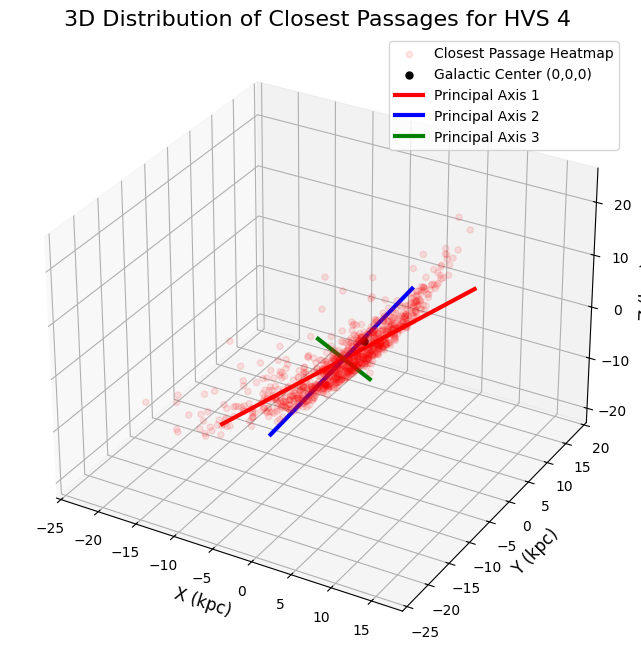

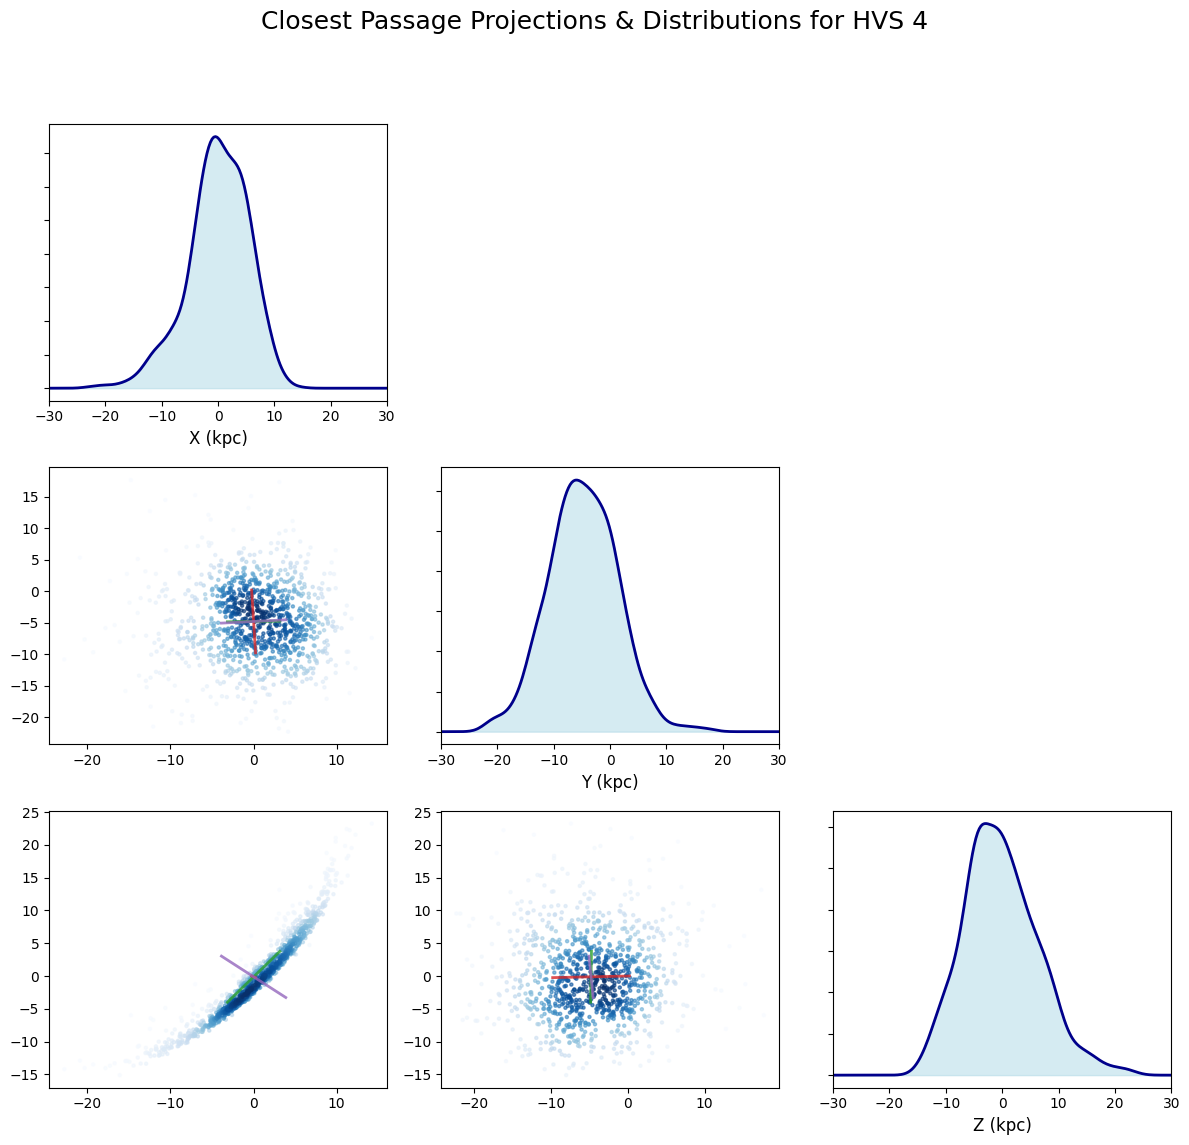

In [ ]:
# pca and 3d plot
pca = PCA(n_components=3)
pca.fit(closest_passages)
mean_passage = pca.mean_
principal_axes = pca.components_
explained_variance = pca.explained_variance_
scale_factor = 3.0 #standard deviations to plot

fig_3d = plt.figure(figsize=(10, 8))
ax = fig_3d.add_subplot(111, projection='3d')
ax.scatter(closest_passages[:, 0], closest_passages[:, 1], closest_passages[:, 2], alpha=0.1, color='red', label='Closest Passage Heatmap')
ax.scatter(0, 0, 0, color='black', s=100, marker='.', label='Galactic Center (0,0,0)')

axis_length_scale = 3 
colors = ['red', 'blue', 'green']
for i, axis in enumerate(principal_axes):
    start_point = mean_passage
    end_point = mean_passage + axis * np.sqrt(explained_variance[i]) * axis_length_scale
    line = np.vstack([start_point - axis * np.sqrt(explained_variance[i]) * axis_length_scale, end_point])
    ax.plot(line[:, 0], line[:, 1], line[:, 2], color=colors[i], lw=3, label=f'Principal Axis {i+1}')

ax.set_xlabel('X (kpc)', fontsize=12)
ax.set_ylabel('Y (kpc)', fontsize=12)
ax.set_zlabel('Z (kpc)', fontsize=12)
ax.set_title(f'3D Distribution of Closest Passages for HVS {hvs_id}', fontsize=16)
ax.legend()
plt.show()

# corner plot
fig_corner, axes = plt.subplots(3, 3, figsize=(12, 12))
fig_corner.suptitle(f'Closest Passage Projections & Distributions for HVS {hvs_id}', fontsize=18)

labels = ['X (kpc)', 'Y (kpc)', 'Z (kpc)']
data = closest_passages
lims = [(-30, 30), (-30, 30), (-30, 30)]

for i in range(3):
    for j in range(3):
        ax = axes[i, j]
        if i==j: # kernel density estimate
            kde = gaussian_kde(data[:, i])
            x_vals = np.linspace(lims[i][0], lims[i][1], 200)
            ax.plot(x_vals, kde(x_vals), color='darkblue', lw=2)
            ax.fill_between(x_vals, kde(x_vals), color='lightblue', alpha=0.5)
            ax.set_xlim(lims[i])
            ax.set_yticklabels([])
            ax.set_xlabel(labels[i], fontsize=12)

        elif i>j: #2d scatter plots with heatmap
            x, y = data[:, j], data[:, i]
            xy = np.vstack([x, y]); 
            z = gaussian_kde(xy)(xy) # weird density trick from online
            idx = z.argsort(); 
            x, y, z = x[idx], y[idx], z[idx] # sort by density
            
            ax.scatter(x, y, c=z, s=5, cmap='Blues', alpha=0.6)
            
            # overlay pca axes projection
            for k, axis in enumerate(principal_axes):
                line = np.vstack([mean_passage - axis * 5, mean_passage + axis * 5])
                ax.plot(line[:, j], line[:, i], color=f'C{k+2}', lw=2, alpha=0.8)
        else:
            ax.axis('off')


plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.show()

#### CASSI presentation plot

#### Mahalanobis distance and p-value

#### KDE and Heatmap with LMC contribution (maybe skip because w/o is sufficient?)

In [ ]:
# NEED TO GET LMC and MW positions over time
# need the center of mass trajectories of MW and LMC from the Garavito-Camargo simulation
# should be (x,y,z) vs time?